In [1]:
import sys
import os

# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# FourierFeatures

Training model with FourierFeatures input processor...


Training:  53%|█████▎    | 53/100 [00:01<00:01, 30.52epoch/s]

Epoch 50: Train Loss = 0.2333


Training: 100%|██████████| 100/100 [00:03<00:00, 28.39epoch/s]


Epoch 100: Train Loss = 0.0632

Validation Forecast Error Metrics:
  MSE   = 0.676699
  RMSE  = 0.822617
  MAE   = 0.679832
Validation metrics: {'mse': np.float32(0.6766988), 'rmse': np.float32(0.82261705), 'mae': np.float32(0.6798318)}


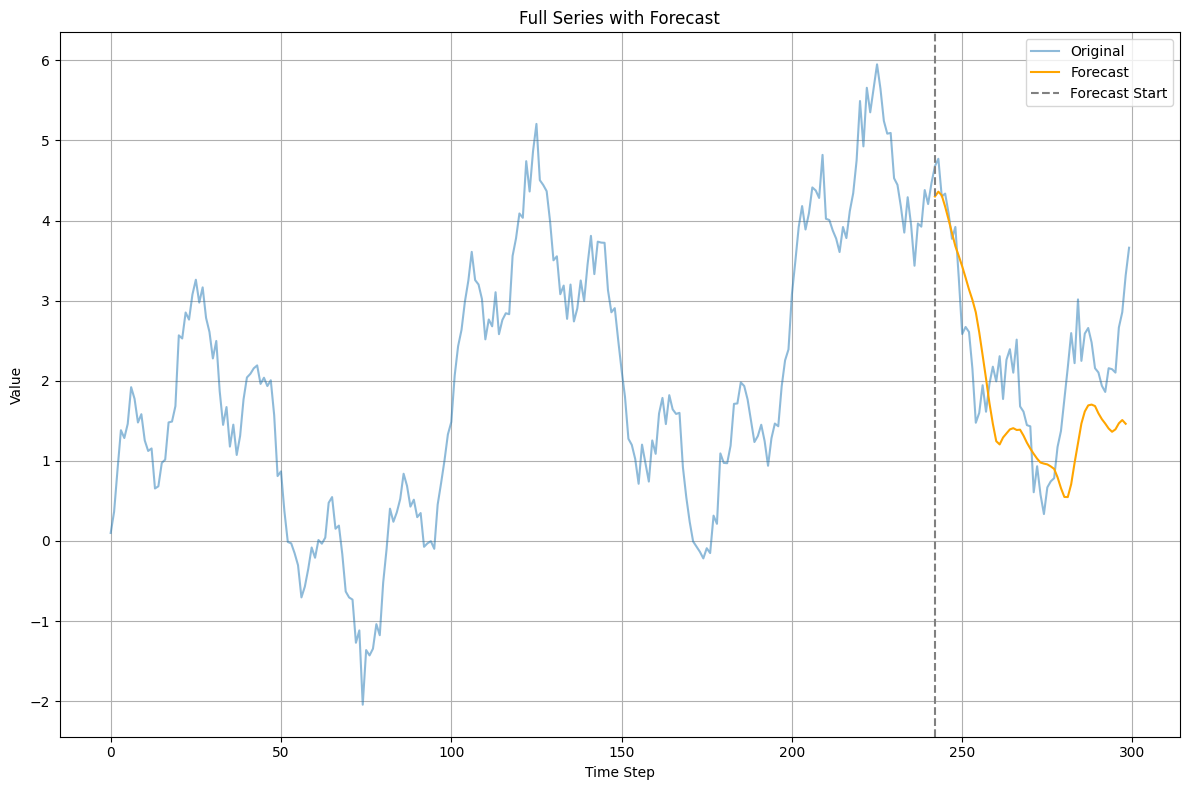


Training baseline model without FourierFeatures...


Training:  56%|█████▌    | 56/100 [00:01<00:01, 33.18epoch/s]

Epoch 50: Train Loss = 0.3743


Training: 100%|██████████| 100/100 [00:03<00:00, 33.27epoch/s]

Epoch 100: Train Loss = 0.0951

Validation Forecast Error Metrics:
  MSE   = 1.344732
  RMSE  = 1.159626
  MAE   = 0.939957
Baseline validation metrics: {'mse': np.float32(1.3447322), 'rmse': np.float32(1.1596259), 'mae': np.float32(0.93995726)}


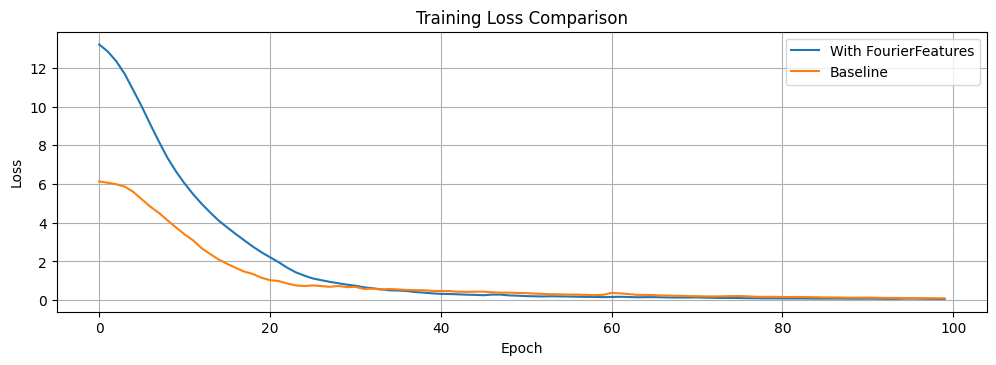

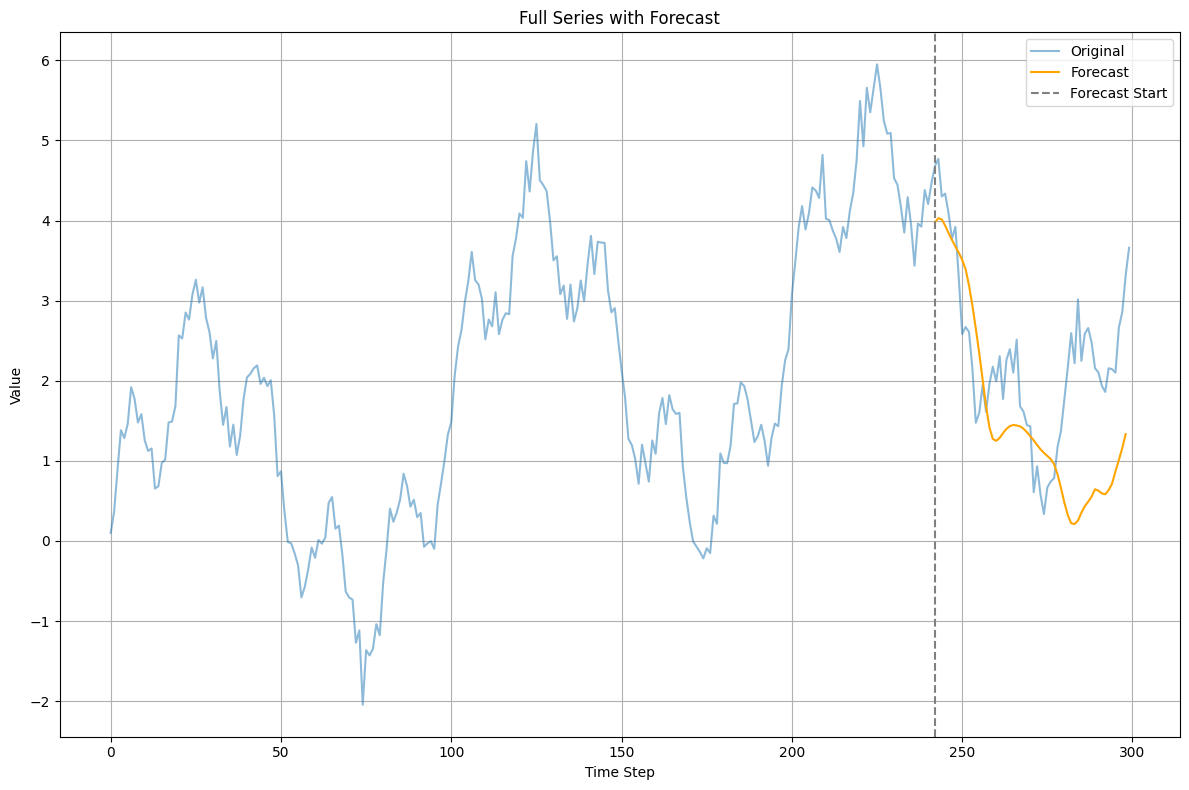

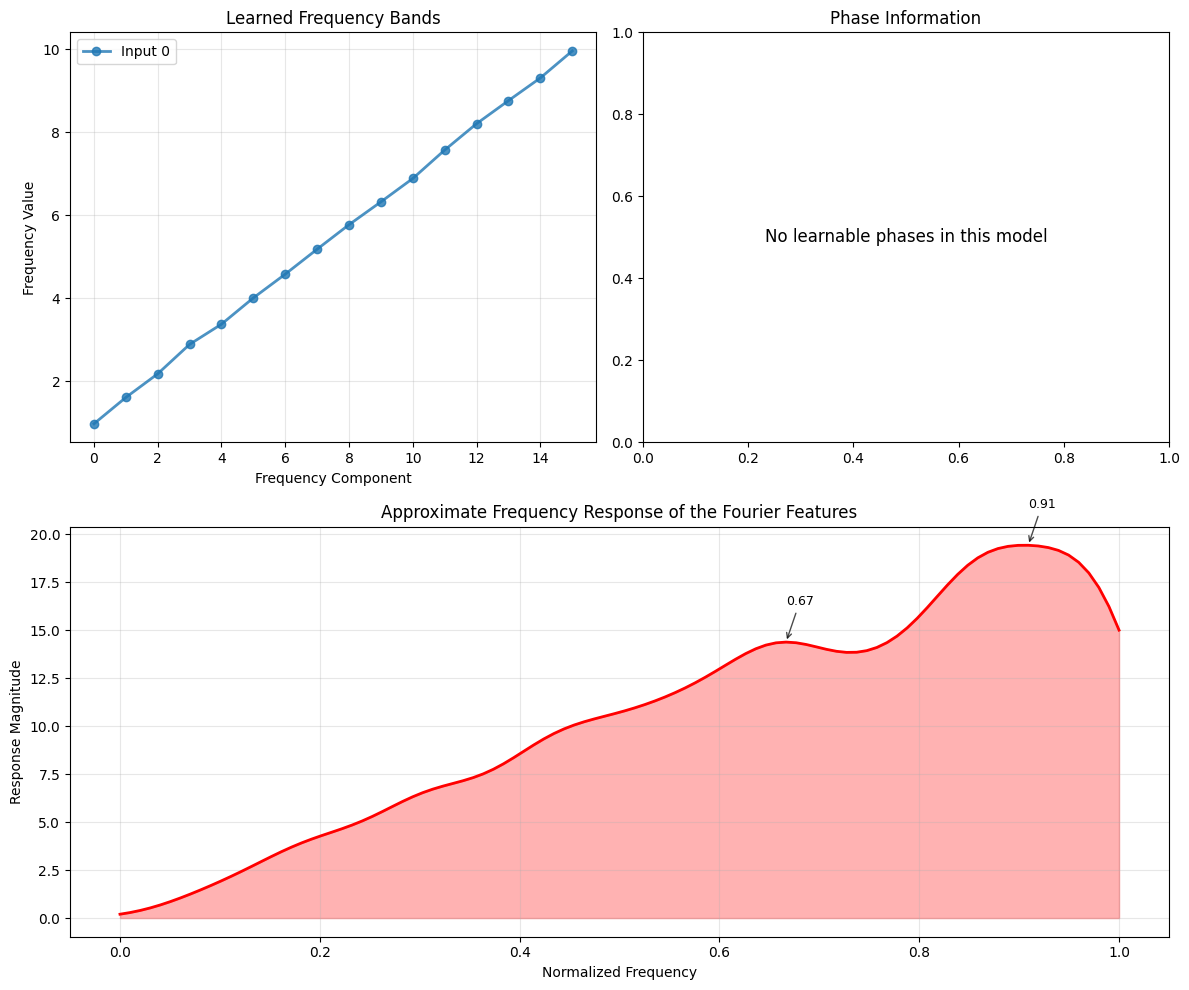

FourierFeatures enhanced model performance metrics:
With FourierFeatures: {'mse': np.float32(0.6766988), 'rmse': np.float32(0.82261705), 'mae': np.float32(0.6798318)}
Baseline: {'mse': np.float32(1.3447322), 'rmse': np.float32(1.1596259), 'mae': np.float32(0.93995726)}
Improvement in MSE: 49.68%


In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from foreblocks import ForecastingModel
from foreblocks import LSTMDecoder, LSTMEncoder
from foreblocks import Trainer
from foreblocks.att import AttentionLayer
from foreblocks.blocks.fourier import FourierFeatures

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Parameters
input_size = 1
hidden_size = 64
num_layers = 1
output_size = 1
target_len = 10
seq_len = 50
total_len = 300  # Total synthetic time series length

# 1. Create the FourierFeatures input preprocessor
fourier_preprocessor = FourierFeatures(
    input_size=input_size,          # Input dimension
    output_size=hidden_size,        # Output dimension (same as hidden_size)
    num_frequencies=16,             # Number of frequency components
    learnable=True,                 # Make frequency parameters learnable
    use_phase=False,                 # Include phase shifts
    use_gaussian=False,              # Use Gaussian random Fourier features (Rahimi & Recht)
)

# 2. Create encoder and decoder
encoder = LSTMEncoder(
    input_size=hidden_size,  # Now input size matches fourier output size
    hidden_size=hidden_size,
    num_layers=num_layers
)

decoder = LSTMDecoder(
    input_size=output_size,
    hidden_size=hidden_size,
    output_size=output_size,
    num_layers=num_layers
)

# Optional attention module (currently commented out)
attention_module = AttentionLayer(
    method='dot',
    attention_backend='xformers',
    encoder_hidden_size=hidden_size,
    decoder_hidden_size=hidden_size,
)

# 3. Create the model with FourierFeatures as input_preprocessor
model = ForecastingModel(
    encoder=encoder,
    decoder=decoder,
    target_len=target_len,
    forecasting_strategy="seq2seq",
    teacher_forcing_ratio=0.5,
    output_size=output_size,
    input_skip_connection=True,
    input_preprocessor=fourier_preprocessor,  # Use our FourierFeatures block
    # attention_module=attention_module,      # Uncomment to use attention
)

# 4. Set up trainer
trainer = Trainer(
    model, 
    optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
    criterion=nn.MSELoss()
)

# 5. Generate synthetic time series with multiple frequency components
t = np.linspace(0, 6 * np.pi, total_len)
# Combine a slow-varying trend, seasonal component, and noise
time_series = (
    0.2 * t +                                  # Linear trend
    2.0 * np.sin(t) +                          # Main frequency
    0.8 * np.sin(5 * t) +                      # Higher frequency component
    0.4 * np.sin(0.2 * t) +                    # Low frequency component
    0.2 * np.random.randn(total_len)           # Noise
)
time_series = torch.tensor(time_series, dtype=torch.float32).unsqueeze(-1)  # Shape: [T, 1]

# 6. Prepare sliding windows for training
def create_sliding_windows(series, input_len, output_len):
    X, Y = [], []
    for i in range(len(series) - input_len - output_len):
        X.append(series[i:i+input_len])
        Y.append(series[i+input_len:i+input_len+output_len])
    return torch.stack(X), torch.stack(Y)

X, Y = create_sliding_windows(time_series, seq_len, target_len)
train_size = int(0.8 * len(X))
X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:], Y[train_size:]

# 7. Create DataLoader
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 8. Train the model
print("Training model with FourierFeatures input processor...")
history = trainer.train(train_loader, epochs=100)  # Increase epochs for better results

# 9. Evaluate the model
metrics = trainer.metrics(X_val, Y_val)
print(f"Validation metrics: {metrics}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 10. Make predictions on validation set
with torch.no_grad():
    X_val = X_val.to(device)
    predictions = model(X_val)

# Plot input sequence
pred_plot = trainer.plot_prediction(X_val, Y_val, full_series=time_series, offset=train_size)
plt.show()

# 12. Ablation study: Compare with a model without FourierFeatures
print("\nTraining baseline model without FourierFeatures...")

# Create baseline model without FourierFeatures
encoder_baseline = LSTMEncoder(input_size, hidden_size, num_layers)
decoder_baseline = LSTMDecoder(output_size, hidden_size, output_size, num_layers)

model_baseline = ForecastingModel(
    encoder=encoder_baseline,
    decoder=decoder_baseline,
    target_len=target_len,
    forecasting_strategy="seq2seq",
    teacher_forcing_ratio=0.5,
    output_size=output_size,
    # No input_preprocessor here
)

trainer_baseline = Trainer(
    model_baseline, 
    optimizer=torch.optim.Adam(model_baseline.parameters(), lr=0.001),
    criterion=nn.MSELoss()
)

# Train baseline model
history_baseline = trainer_baseline.train(train_loader, epochs=100)

# Evaluate baseline model
metrics_baseline = trainer_baseline.metrics(X_val, Y_val)
print(f"Baseline validation metrics: {metrics_baseline}")

# Make predictions with baseline model
with torch.no_grad():
    predictions_baseline = model_baseline(X_val)

# Compare results
plt.figure(figsize=(12, 8))

# Plot training losses
plt.subplot(2, 1, 1)
plt.plot(history['train_losses'], label='With FourierFeatures')
plt.plot(history_baseline['train_losses'], label='Baseline')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()
# Plot predictions for model with FourierFeatures
pred_plot_baseline = trainer_baseline.plot_prediction(X_val, Y_val, full_series=time_series, offset=train_size)
plt.show()

# Analysis of Fourier Features' impact
# Create a more informative visualization
plt.figure(figsize=(12, 10))

# Create a subplot for frequencies
plt.subplot(2, 2, 1)
try:
    # Safely extract weights from the FourierFeatures preprocessor
    frequencies = fourier_preprocessor.freq_matrix.detach().cpu().numpy()
    
    # Plot magnitude of frequencies
    if hasattr(fourier_preprocessor, 'use_gaussian') and fourier_preprocessor.use_gaussian:
        im = plt.imshow(np.abs(frequencies), aspect='auto', cmap='viridis')
        plt.colorbar(im, label='Frequency Magnitude')
        plt.title('Learned Fourier Feature Frequencies')
        plt.ylabel('Frequency Component')
        plt.xlabel('Input Dimension')
    else:
        for i in range(input_size):
            plt.plot(frequencies[i, :], 'o-', linewidth=2, alpha=0.8, label=f'Input {i}')
        plt.title('Learned Frequency Bands')
        plt.xlabel('Frequency Component')
        plt.ylabel('Frequency Value')
        plt.grid(True, alpha=0.3)
        if input_size <= 5:  # Only show legend if not too many inputs
            plt.legend()
except Exception as e:
    plt.title(f"Error extracting frequencies: {str(e)}")

# Create a subplot for phases if they exist
plt.subplot(2, 2, 2)
try:
    if hasattr(fourier_preprocessor, 'phase') and fourier_preprocessor.phase is not None:
        phases = fourier_preprocessor.phase.detach().cpu().numpy()
        
        if hasattr(fourier_preprocessor, 'use_gaussian') and fourier_preprocessor.use_gaussian:
            plt.plot(phases, 'o-', linewidth=2, markersize=6, color='orange')
            plt.title('Learned Phase Shifts')
            plt.xlabel('Frequency Component')
            plt.ylabel('Phase (radians)')
        else:
            for i in range(input_size):
                plt.plot(phases[i, :], 'o-', linewidth=2, alpha=0.8, label=f'Input {i}')
            plt.title('Learned Phase Shifts')
            plt.xlabel('Frequency Component')
            plt.ylabel('Phase (radians)')
            if input_size <= 5:  # Only show legend if not too many inputs
                plt.legend()
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, "No learnable phases in this model", 
                 horizontalalignment='center', verticalalignment='center',
                 transform=plt.gca().transAxes, fontsize=12)
        plt.title('Phase Information')
except Exception as e:
    plt.title(f"Error extracting phases: {str(e)}")

# Add a frequency response visualization (shows which frequencies are emphasized)
plt.subplot(2, 1, 2)
try:
    # Generate synthetic frequency response plot
    if hasattr(fourier_preprocessor, 'num_frequencies'):
        num_freqs = fourier_preprocessor.num_frequencies
        freq_response = np.zeros(100)
        
        # For each learned frequency, add a peak at that location
        x_freqs = np.linspace(0, 1, 100)
        
        # We'll use the magnitude of each frequency component to create a response curve
        for i in range(min(frequencies.shape[0], input_size)):
            for j in range(min(frequencies.shape[1], num_freqs)):
                # Get the magnitude of this frequency
                if hasattr(fourier_preprocessor, 'use_gaussian') and fourier_preprocessor.use_gaussian:
                    freq_value = np.abs(frequencies[j, i]) 
                else:
                    freq_value = frequencies[i, j]
                
                # Add a peak at this frequency
                peak_loc = int((freq_value / (fourier_preprocessor.freq_scale if hasattr(fourier_preprocessor, 'freq_scale') else 10.0)) * 100)
                peak_loc = min(max(0, peak_loc), 99)  # Ensure within bounds
                
                # Add a Gaussian peak
                for k in range(100):
                    dist = abs(k - peak_loc)
                    freq_response[k] += np.exp(-0.5 * (dist / 5)**2) * np.abs(freq_value)
        
        # Plot the frequency response
        plt.plot(x_freqs, freq_response, 'r-', linewidth=2)
        plt.fill_between(x_freqs, 0, freq_response, alpha=0.3, color='red')
        plt.title('Approximate Frequency Response of the Fourier Features')
        plt.xlabel('Normalized Frequency')
        plt.ylabel('Response Magnitude')
        plt.grid(True, alpha=0.3)
        
        # Add annotations for dominant frequencies
        peaks = []
        for i in range(1, 99):
            if freq_response[i] > freq_response[i-1] and freq_response[i] > freq_response[i+1]:
                peaks.append((i, freq_response[i]))
        
        # Sort by magnitude and take top 5
        peaks.sort(key=lambda x: x[1], reverse=True)
        for i, (idx, val) in enumerate(peaks[:5]):
            if val > 0.1 * max(freq_response):  # Only annotate significant peaks
                plt.annotate(f"{x_freqs[idx]:.2f}", 
                             xy=(x_freqs[idx], val),
                             xytext=(x_freqs[idx], val + 0.1 * max(freq_response)),
                             arrowprops=dict(arrowstyle="->", color='black', alpha=0.7),
                             fontsize=9)
    else:
        plt.text(0.5, 0.5, "Cannot generate frequency response plot", 
                 horizontalalignment='center', verticalalignment='center',
                 transform=plt.gca().transAxes, fontsize=12)
except Exception as e:
    plt.text(0.5, 0.5, f"Error creating frequency response: {str(e)}", 
             horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes, fontsize=10)

plt.tight_layout()
plt.show()


print("FourierFeatures enhanced model performance metrics:")
print(f"With FourierFeatures: {metrics}")
print(f"Baseline: {metrics_baseline}")
improvement = (metrics_baseline['mse'] - metrics['mse']) / metrics_baseline['mse'] * 100
print(f"Improvement in MSE: {improvement:.2f}%")

# Adaptive FourierFeatures

Training model with AdaptiveFourierFeatures input processor...


Training:  54%|█████▍    | 54/100 [00:02<00:01, 27.03epoch/s]

Epoch 50: Train Loss = 0.1444


Training: 100%|██████████| 100/100 [00:03<00:00, 26.81epoch/s]


Epoch 100: Train Loss = 0.0568

Validation Forecast Error Metrics:
  MSE   = 1.294092
  RMSE  = 1.137582
  MAE   = 0.989882
Validation metrics: {'mse': np.float32(1.2940918), 'rmse': np.float32(1.1375816), 'mae': np.float32(0.9898821)}


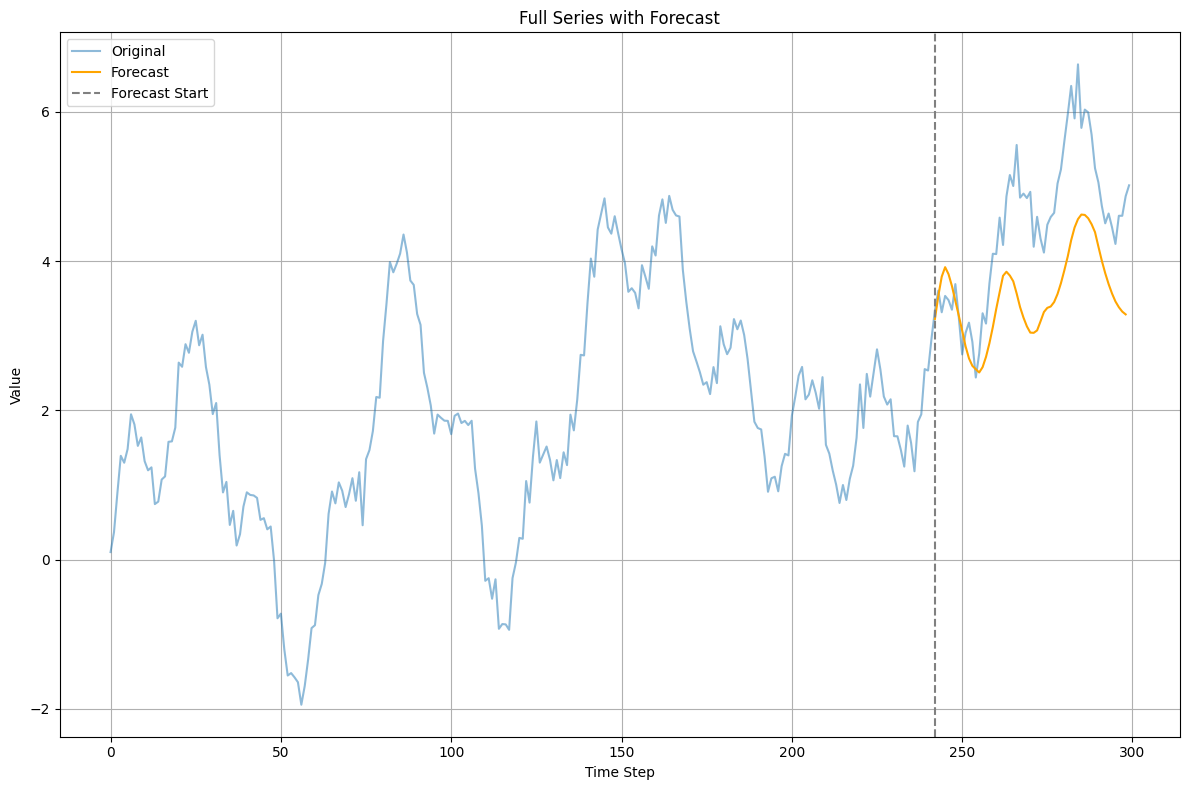


Training baseline model without AdaptiveFourierFeatures...


Training:  56%|█████▌    | 56/100 [00:01<00:01, 33.25epoch/s]

Epoch 50: Train Loss = 0.2300


Training: 100%|██████████| 100/100 [00:03<00:00, 30.96epoch/s]


Epoch 100: Train Loss = 0.1479

Validation Forecast Error Metrics:
  MSE   = 2.580005
  RMSE  = 1.606240
  MAE   = 1.388882
Baseline validation metrics: {'mse': np.float32(2.5800054), 'rmse': np.float32(1.6062396), 'mae': np.float32(1.3888819)}


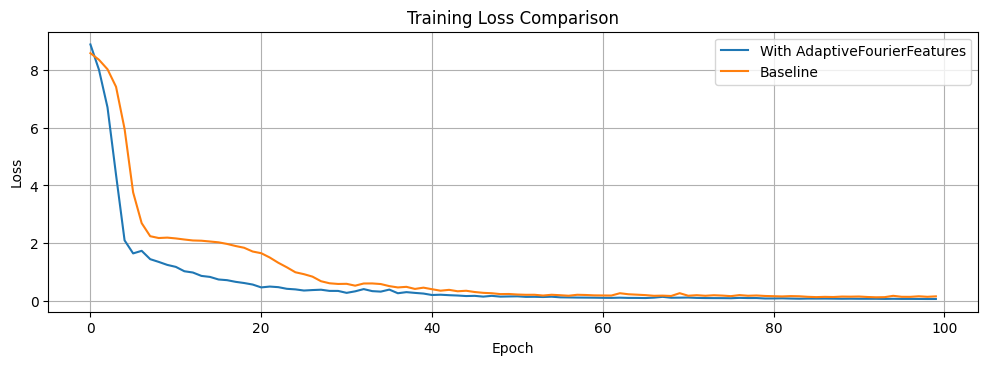

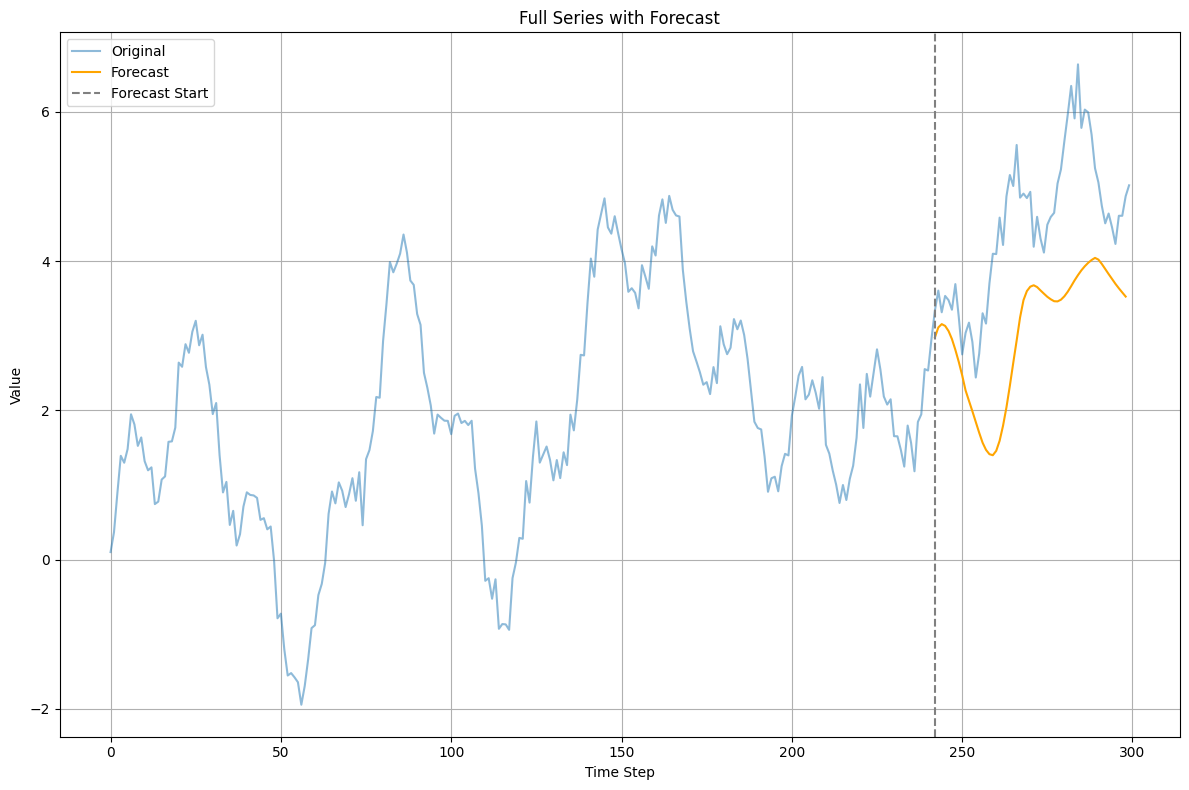

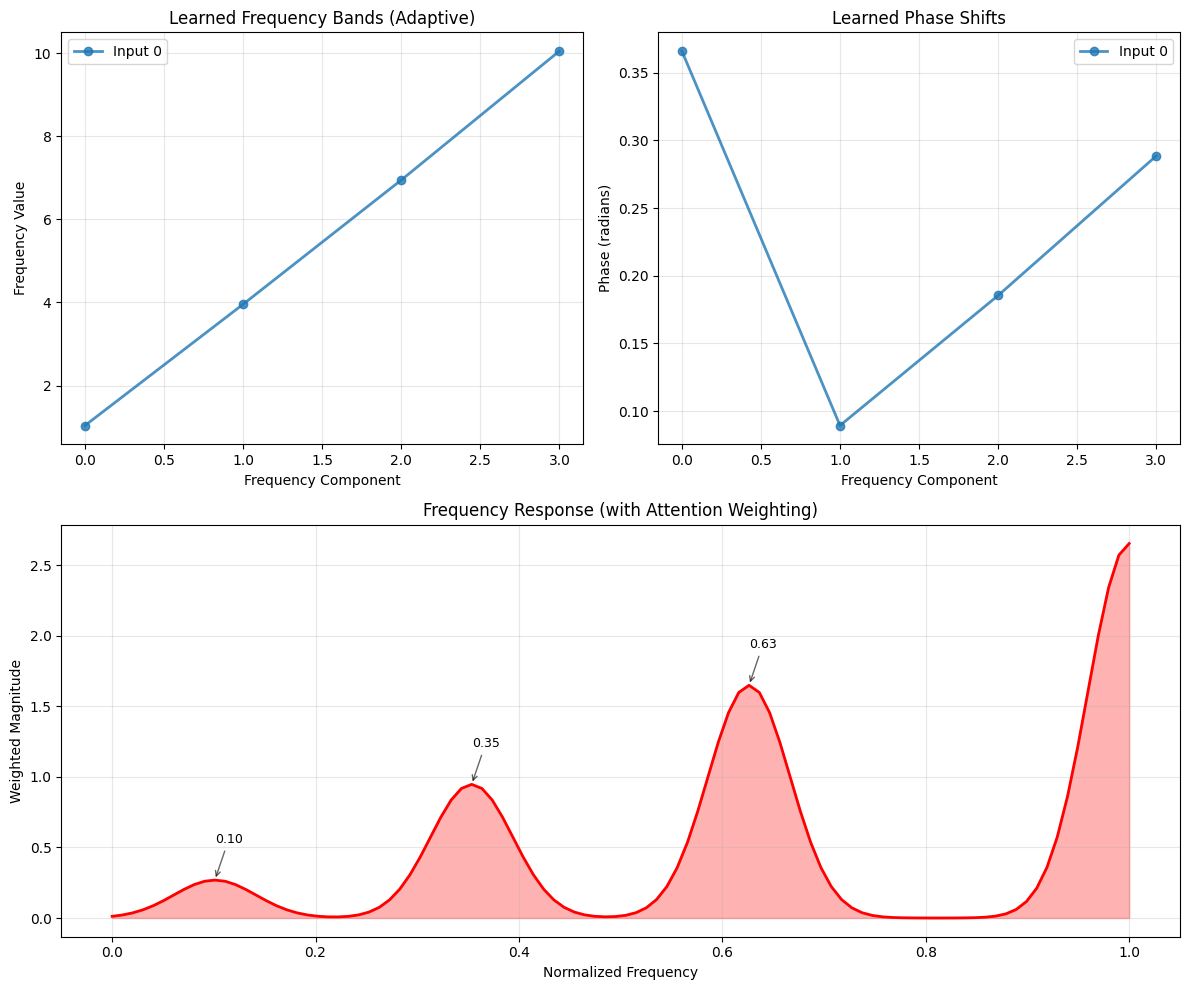

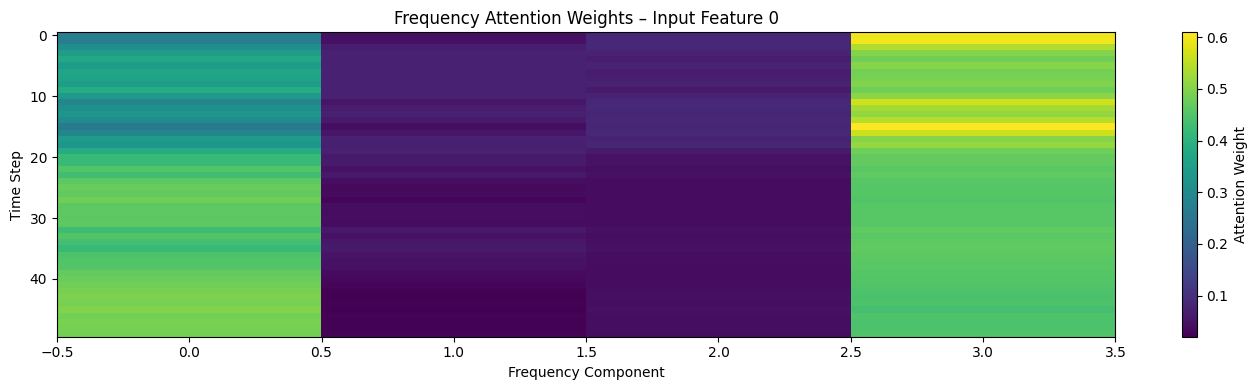

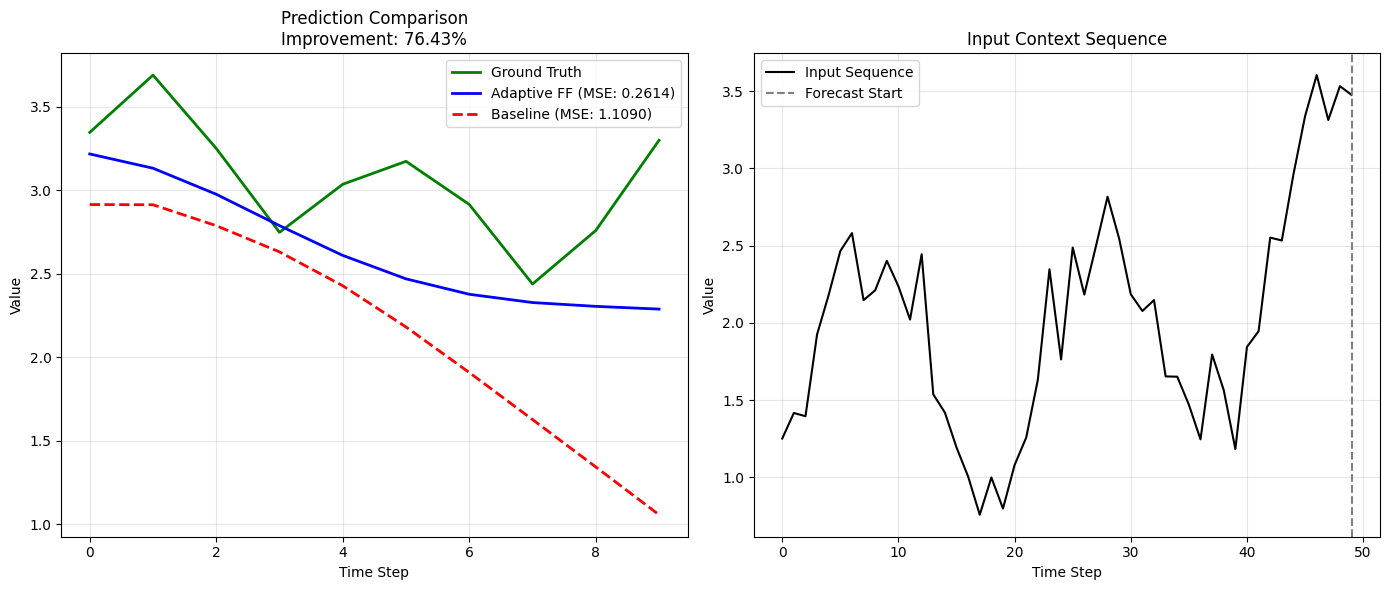

AdaptiveFourierFeatures enhanced model performance metrics:
With AdaptiveFourierFeatures: {'mse': np.float32(1.2940918), 'rmse': np.float32(1.1375816), 'mae': np.float32(0.9898821)}
Baseline: {'mse': np.float32(2.5800054), 'rmse': np.float32(1.6062396), 'mae': np.float32(1.3888819)}
Improvement in MSE: 49.84%


In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from foreblocks import ForecastingModel
from foreblocks import LSTMDecoder, LSTMEncoder
from foreblocks import Trainer
from foreblocks.att import AttentionLayer
from foreblocks.blocks.fourier import AdaptiveFourierFeatures  # Import the adaptive version

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Parameters
input_size = 1
hidden_size = 64
num_layers = 1
output_size = 1
target_len = 10
seq_len = 50
total_len = 300  # Total synthetic time series length

com_size = 8

# 1. Create the AdaptiveFourierFeatures input preprocessor
fourier_preprocessor = AdaptiveFourierFeatures(
    input_size=input_size,          # Input dimension
    output_size=com_size,        # Output dimension (same as hidden_size)
    num_frequencies=4,             # Number of frequency components
    learnable=True,                 # Make frequency parameters learnable
    use_phase=True,                 # Include phase shifts
    freq_attention_heads=4,         # Use 4 attention heads
)

# 2. Create encoder and decoder
encoder = LSTMEncoder(
    input_size=com_size,  # Now input size matches fourier output size
    hidden_size=hidden_size,
    num_layers=num_layers
)

decoder = LSTMDecoder(
    input_size=output_size,
    hidden_size=hidden_size,
    output_size=output_size,
    num_layers=num_layers
)


# 3. Create the model with AdaptiveFourierFeatures as input_preprocessor
model = ForecastingModel(
    encoder=encoder,
    decoder=decoder,
    target_len=target_len,
    forecasting_strategy="seq2seq",
    teacher_forcing_ratio=0.5,
    output_size=output_size,
    input_skip_connection=False,
    input_preprocessor=fourier_preprocessor,  # Use our AdaptiveFourierFeatures block
)

# 4. Set up trainer
trainer = Trainer(
    model, 
    optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
    criterion=nn.MSELoss()
)

# 5. Generate a more complex synthetic time series to demonstrate the advantages
# of adaptive Fourier features on varying frequency components
t = np.linspace(0, 6 * np.pi, total_len)

# Create a time series with frequency that changes over time
changing_freq = np.sin(t * (1 + 0.5 * np.sin(0.2 * t)))  # Frequency modulation

# Combine various components
time_series = (
    0.2 * t +                                  # Linear trend
    2.0 * changing_freq +                      # Varying frequency component
    0.8 * np.sin(5 * t) +                      # Higher frequency component
    0.4 * np.sin(0.2 * t) +                    # Low frequency component
    0.2 * np.random.randn(total_len)           # Noise
)
time_series = torch.tensor(time_series, dtype=torch.float32).unsqueeze(-1)  # Shape: [T, 1]

# 6. Prepare sliding windows for training
def create_sliding_windows(series, input_len, output_len):
    X, Y = [], []
    for i in range(len(series) - input_len - output_len):
        X.append(series[i:i+input_len])
        Y.append(series[i+input_len:i+input_len+output_len])
    return torch.stack(X), torch.stack(Y)

X, Y = create_sliding_windows(time_series, seq_len, target_len)
train_size = int(0.8 * len(X))
X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:], Y[train_size:]

# 7. Create DataLoader
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 8. Train the model
print("Training model with AdaptiveFourierFeatures input processor...")
history = trainer.train(train_loader, epochs=100)  # Increase epochs for better results

# 9. Evaluate the model
metrics = trainer.metrics(X_val, Y_val)
print(f"Validation metrics: {metrics}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 10. Make predictions on validation set
with torch.no_grad():
    X_val = X_val.to(device)
    predictions = model(X_val)

# Plot input sequence
pred_plot = trainer.plot_prediction(X_val, Y_val, full_series=time_series, offset=train_size)
plt.show()

# 12. Ablation study: Compare with a model without AdaptiveFourierFeatures
print("\nTraining baseline model without AdaptiveFourierFeatures...")

# Create baseline model without AdaptiveFourierFeatures
encoder_baseline = LSTMEncoder(input_size, hidden_size, num_layers)
decoder_baseline = LSTMDecoder(output_size, hidden_size, output_size, num_layers)

model_baseline = ForecastingModel(
    encoder=encoder_baseline,
    decoder=decoder_baseline,
    target_len=target_len,
    forecasting_strategy="seq2seq",
    teacher_forcing_ratio=0.5,
    output_size=output_size,
    # No input_preprocessor here
)

trainer_baseline = Trainer(
    model_baseline, 
    optimizer=torch.optim.Adam(model_baseline.parameters(), lr=0.001),
    criterion=nn.MSELoss()
)

# Train baseline model
history_baseline = trainer_baseline.train(train_loader, epochs=100)

# Evaluate baseline model
metrics_baseline = trainer_baseline.metrics(X_val, Y_val)
print(f"Baseline validation metrics: {metrics_baseline}")

# Make predictions with baseline model
with torch.no_grad():
    predictions_baseline = model_baseline(X_val)

# Compare results
plt.figure(figsize=(12, 8))

# Plot training losses
plt.subplot(2, 1, 1)
plt.plot(history['train_losses'], label='With AdaptiveFourierFeatures')
plt.plot(history_baseline['train_losses'], label='Baseline')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()
# Plot predictions for model with AdaptiveFourierFeatures
pred_plot_baseline = trainer_baseline.plot_prediction(X_val, Y_val, full_series=time_series, offset=train_size)
plt.show()

# Analysis of Fourier Features' impact
# Create a more informative visualization
plt.figure(figsize=(12, 10))

# Create a subplot for frequencies
plt.subplot(2, 2, 1)
try:
    # Safely extract weights from the AdaptiveFourierFeatures preprocessor
    frequencies = fourier_preprocessor.freq_matrix.detach().cpu().numpy()
    
    # Plot magnitude of frequencies
    for i in range(input_size):
        plt.plot(frequencies[i, :], 'o-', linewidth=2, alpha=0.8, label=f'Input {i}')
    plt.title('Learned Frequency Bands (Adaptive)')
    plt.xlabel('Frequency Component')
    plt.ylabel('Frequency Value')
    plt.grid(True, alpha=0.3)
    if input_size <= 5:  # Only show legend if not too many inputs
        plt.legend()
except Exception as e:
    plt.title(f"Error extracting frequencies: {str(e)}")

# Create a subplot for phases if they exist
plt.subplot(2, 2, 2)
try:
    if hasattr(fourier_preprocessor, 'phase') and fourier_preprocessor.phase is not None:
        phases = fourier_preprocessor.phase.detach().cpu().numpy()
        
        for i in range(input_size):
            plt.plot(phases[i, :], 'o-', linewidth=2, alpha=0.8, label=f'Input {i}')
        plt.title('Learned Phase Shifts')
        plt.xlabel('Frequency Component')
        plt.ylabel('Phase (radians)')
        if input_size <= 5:  # Only show legend if not too many inputs
            plt.legend()
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, "No learnable phases in this model", 
                 horizontalalignment='center', verticalalignment='center',
                 transform=plt.gca().transAxes, fontsize=12)
        plt.title('Phase Information')
except Exception as e:
    plt.title(f"Error extracting phases: {str(e)}")

# Add a frequency response visualization (shows which frequencies are emphasized)
plt.subplot(2, 1, 2)
try:
    if hasattr(fourier_preprocessor, 'freq_matrix') and hasattr(fourier_preprocessor, 'freq_scale'):
        num_freqs = fourier_preprocessor.num_frequencies
        input_dims = fourier_preprocessor.input_size
        x_freqs = np.linspace(0, 1, 100)
        freq_response = np.zeros_like(x_freqs)

        # Get scaled frequency values
        scaled_freqs = (fourier_preprocessor.freq_matrix * fourier_preprocessor.freq_scale).detach().cpu().numpy()

        # Average attention weights (if available)
        attn_weights_avg = None
        if hasattr(fourier_preprocessor, 'attn_weights_log') and len(fourier_preprocessor.attn_weights_log) > 0:
            attn_weights_avg = [w.mean(dim=1).squeeze(0).cpu().numpy() for w in fourier_preprocessor.attn_weights_log]  # [input_dim][num_freqs]

        # Build response
        for i in range(input_dims):
            for j in range(num_freqs):
                freq_val = scaled_freqs[i, j]
                norm_freq = freq_val / (scaled_freqs.max() + 1e-6)  # Normalize to [0, 1]
                peak_loc = int(norm_freq * len(x_freqs))
                peak_loc = np.clip(peak_loc, 0, len(x_freqs) - 1)

                attn_weight = attn_weights_avg[i][j] if attn_weights_avg is not None else 1.0
                magnitude = np.abs(freq_val) * attn_weight

                for k in range(len(x_freqs)):
                    dist = np.abs(k - peak_loc)
                    freq_response[k] += magnitude * np.exp(-0.5 * (dist / 4)**2)

        # Plot
        plt.plot(x_freqs, freq_response, 'r-', linewidth=2)
        plt.fill_between(x_freqs, 0, freq_response, alpha=0.3, color='red')
        plt.title('Frequency Response (with Attention Weighting)')
        plt.xlabel('Normalized Frequency')
        plt.ylabel('Weighted Magnitude')
        plt.grid(True, alpha=0.3)

        # Annotate top 5 peaks
        peaks = [(i, freq_response[i]) for i in range(1, 99)
                 if freq_response[i] > freq_response[i - 1] and freq_response[i] > freq_response[i + 1]]
        peaks.sort(key=lambda x: x[1], reverse=True)
        for i, (idx, val) in enumerate(peaks[:5]):
            if val > 0.1 * freq_response.max():
                plt.annotate(f"{x_freqs[idx]:.2f}",
                             xy=(x_freqs[idx], val),
                             xytext=(x_freqs[idx], val + 0.1 * freq_response.max()),
                             arrowprops=dict(arrowstyle="->", color='black', alpha=0.6),
                             fontsize=9)
    else:
        plt.text(0.5, 0.5, "Missing frequency data", ha='center', va='center', transform=plt.gca().transAxes)
except Exception as e:
    plt.text(0.5, 0.5, f"Error: {str(e)}", ha='center', va='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()


# Add a visualization of the attention weights
try:
    if hasattr(fourier_preprocessor, 'attn_weights_log') and len(fourier_preprocessor.attn_weights_log) > 0:
        plt.figure(figsize=(14, 4 * len(fourier_preprocessor.attn_weights_log)))

        for i, attn_tensor in enumerate(fourier_preprocessor.attn_weights_log):
            # attn_tensor: [batch=1, seq_len, num_freqs]
            attn_matrix = attn_tensor.squeeze(0).cpu().numpy()  # [seq_len, num_freqs]

            plt.subplot(len(fourier_preprocessor.attn_weights_log), 1, i + 1)
            plt.imshow(attn_matrix, aspect='auto', cmap='viridis')
            plt.colorbar(label='Attention Weight')
            plt.title(f'Frequency Attention Weights – Input Feature {i}')
            plt.xlabel('Frequency Component')
            plt.ylabel('Time Step')

        plt.tight_layout()
        plt.show()
    else:
        print("No attention weights logged yet. Run a forward pass with a sample batch first.")
except Exception as e:
    print(f"Could not visualize attention weights: {str(e)}")


# Add a supplementary plot showing example comparison
try:
    plt.figure(figsize=(14, 6))
    
    # Example prediction comparison
    example_idx = min(5, len(X_val)-1)  # Avoid index errors
    
    # Calculate errors for this example
    gt = Y_val[example_idx, :, 0].cpu().numpy()
    pred_ff = predictions[example_idx, :, 0].cpu().numpy()
    pred_baseline = predictions_baseline[example_idx, :, 0].cpu().numpy()
    
    mse_ff = np.mean((gt - pred_ff) ** 2)
    mse_baseline = np.mean((gt - pred_baseline) ** 2)
    improvement = (mse_baseline - mse_ff) / mse_baseline * 100
    
    plt.subplot(1, 2, 1)
    plt.plot(gt, 'g-', linewidth=2, label='Ground Truth')
    plt.plot(pred_ff, 'b-', linewidth=2, label=f'Adaptive FF (MSE: {mse_ff:.4f})')
    plt.plot(pred_baseline, 'r--', linewidth=2, label=f'Baseline (MSE: {mse_baseline:.4f})')
    plt.title(f'Prediction Comparison\nImprovement: {improvement:.2f}%')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Show input sequence for context
    plt.subplot(1, 2, 2)
    plt.plot(X_val[example_idx, :, 0].cpu().numpy(), 'k-', label='Input Sequence')
    plt.axvline(x=seq_len-1, color='gray', linestyle='--', label='Forecast Start')
    plt.title('Input Context Sequence')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not create example comparison: {str(e)}")

print("AdaptiveFourierFeatures enhanced model performance metrics:")
print(f"With AdaptiveFourierFeatures: {metrics}")
print(f"Baseline: {metrics_baseline}")
improvement = (metrics_baseline['mse'] - metrics['mse']) / metrics_baseline['mse'] * 100
print(f"Improvement in MSE: {improvement:.2f}%")